In [1]:
%matplotlib inline


# Forward Simulation of Total Magnetic Intensity Data

Here we use the module *SimPEG.potential_fields.magnetics* to predict magnetic
data for a magnetic susceptibility model. We simulate the data on a tensor mesh.
For this tutorial, we focus on the following:

    - How to define the survey
    - How to predict magnetic data for a susceptibility model
    - How to include surface topography
    - The units of the physical property model and resulting data


## Import Modules




In [2]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

from discretize import TensorMesh
from discretize.utils import mkvc
from SimPEG.utils import plot2Ddata, model_builder, surface2ind_topo
from SimPEG import maps, utils
from SimPEG.potential_fields import magnetics

write_output = False

# sphinx_gallery_thumbnail_number = 2

## Topography

Surface topography is defined as an (N, 3) numpy array. We create it here but
topography could also be loaded from a file.




In [3]:
[x_topo, y_topo] = np.meshgrid(np.linspace(-20, 20, 4), np.linspace(-20, 20, 4))
z_topo = x_topo *0
x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
xyz_topo = np.c_[x_topo, y_topo, z_topo]
print(xyz_topo)

[[-20.         -20.          -0.        ]
 [-20.          -6.66666667  -0.        ]
 [-20.           6.66666667  -0.        ]
 [-20.          20.          -0.        ]
 [ -6.66666667 -20.          -0.        ]
 [ -6.66666667  -6.66666667  -0.        ]
 [ -6.66666667   6.66666667  -0.        ]
 [ -6.66666667  20.          -0.        ]
 [  6.66666667 -20.           0.        ]
 [  6.66666667  -6.66666667   0.        ]
 [  6.66666667   6.66666667   0.        ]
 [  6.66666667  20.           0.        ]
 [ 20.         -20.           0.        ]
 [ 20.          -6.66666667   0.        ]
 [ 20.           6.66666667   0.        ]
 [ 20.          20.           0.        ]]


## Defining the Survey

Here, we define survey that will be used for the simulation. Magnetic
surveys are simple to create. The user only needs an (N, 3) array to define
the xyz locations of the observation locations, the list of field components
which are to be modeled and the properties of the Earth's field.




In [4]:
# Define the observation locations as an (N, 3) numpy array or load them.

"x and y manage the size of the anomali cell"

x = np.linspace(-1, 1, 17)
y = np.linspace(-1, 1, 17)
x, y = np.meshgrid(x, y)
x, y = mkvc(x.T), mkvc(y.T)
fun_interp = LinearNDInterpolator(np.c_[x_topo, y_topo], z_topo)
z = fun_interp(np.c_[x, y]) + 0.2  # Flight height 10 m above surface.
receiver_locations = np.c_[x, y, z]

# Define the component(s) of the field we want to simulate as a list of strings.
# Here we simulation total magnetic intensity data.
components = ["tmi"]

# Use the observation locations and components to define the receivers. To
# simulate data, the receivers must be defined as a list.
receiver_list = magnetics.receivers.Point(receiver_locations, components=components)

receiver_list = [receiver_list]

# Define the inducing field H0 = (intensity [nT], inclination [deg], declination [deg])
inclination = 66.449
declination = 1.9
strength = 49063.8
inducing_field = (strength, inclination, declination)

source_field = magnetics.sources.SourceField(
    receiver_list=receiver_list, parameters=inducing_field
)

# Define the survey
survey = magnetics.survey.Survey(source_field)

## Defining a Tensor Mesh

Here, we create the tensor mesh that will be used for the forward simulation.




In [5]:
#########
"This manage the grillimg of the mesh"
#########
dh = 0.05
hx = [(dh, 5, -1.3), (dh, 45), (dh, 5, 1.3)]
hy = [(dh, 5, -1.3), (dh, 45), (dh, 5, 1.3)]
hz = [(dh, 5, -1.3), (dh, 25)]
mesh = TensorMesh([hx, hy, hz], "CCN")

## Defining a Susceptibility Model

Here, we create the model that will be used to predict magnetic data
and the mapping from the model to the mesh. The model
consists of a susceptible sphere in a less susceptible host.




C:\ProgramData\Anaconda3\lib\site-packages\discretize\utils\code_utils.py:182: FutureWarning: TensorMesh.vectorNx has been deprecated, please use TensorMesh.nodes_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
C:\ProgramData\Anaconda3\lib\site-packages\discretize\utils\code_utils.py:182: FutureWarning: TensorMesh.vectorNy has been deprecated, please use TensorMesh.nodes_y. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
C:\ProgramData\Anaconda3\lib\site-packages\discretize\utils\code_utils.py:182: FutureWarning: TensorMesh.vectorCCx has been deprecated, please use TensorMesh.cell_centers_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
C:\ProgramData\Anaconda3\lib\site-packages\discretize\utils\code_utils.py:182: FutureWarning: TensorMesh.vectorCCy has been deprecated, please use TensorMesh.cell_centers_y. It will be removed in version 1.0.0 of discretize.
  warnings.war

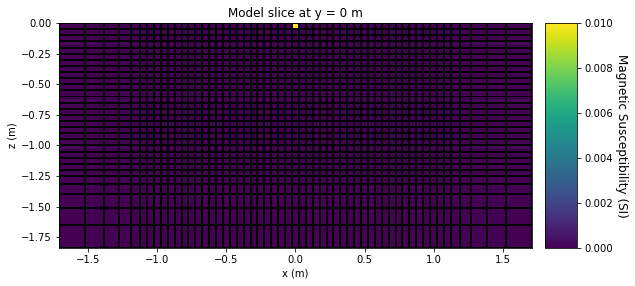

In [6]:
# Find cells that are active in the forward modeling (cells below surface)
ind_active = surface2ind_topo(mesh, xyz_topo)


# Define susceptibility values for each unit in SI
background_susceptibility = 0
sphere_susceptibility = 0.01

# Define mapping from model to active cells
nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)  # model is a vlue for each active cell

# Define model. Models in SimPEG are vector arrays
model = background_susceptibility * np.ones(ind_active.sum())
ind_sphere = model_builder.getIndicesSphere(
    np.r_[0.0, 0.0, -0.02], 0.02, mesh.cell_centers
)
ind_sphere = ind_sphere[ind_active]
model[ind_sphere] = sphere_susceptibility





# Plot Model
fig = plt.figure(figsize=(9, 4))

plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
mesh.plotSlice(
    plotting_map * model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.nCy / 2),
    grid=True,
    clim=(np.min(model), np.max(model)),
)
ax1.set_title("Model slice at y = 0 m")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.78])
norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, orientation="vertical")
cbar.set_label("Magnetic Susceptibility (SI)", rotation=270, labelpad=15, size=12)

plt.show()


## Simulation: TMI Data for a Susceptibility Model

Here we demonstrate how to predict magnetic data for a magnetic
susceptibility model using the integral formulation.




C:\ProgramData\Anaconda3\lib\site-packages\discretize\base\base_tensor_mesh.py:1019: FutureWarning: hx has been deprecated, please access as mesh.h[0]
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\discretize\base\base_tensor_mesh.py:1036: FutureWarning: hy has been deprecated, please access as mesh.h[1]
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\discretize\base\base_tensor_mesh.py:1053: FutureWarning: hz has been deprecated, please access as mesh.h[2]
  warnings.warn(


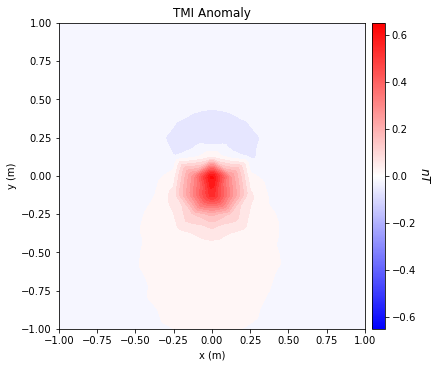

In [7]:
# Define the forward simulation. By setting the 'store_sensitivities' keyword
# argument to "forward_only", we simulate the data without storing the sensitivities
simulation = magnetics.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    model_type="scalar",
    chiMap=model_map,
    actInd=ind_active,
    store_sensitivities="forward_only",
)

# Compute predicted data for a susceptibility model
dpred = simulation.dpred(model)

# Plot
fig = plt.figure(figsize=(6, 5))
v_max = np.max(np.abs(dpred))

ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.85])
plot2Ddata(
    receiver_list[0].locations,
    dpred,
    ax=ax1,
    ncontour=30,
    clim=(-v_max, v_max),
    contourOpts={"cmap": "bwr"},
)
ax1.set_title("TMI Anomaly")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.87, 0.1, 0.03, 0.85])
norm = mpl.colors.Normalize(vmin=-np.max(np.abs(dpred)), vmax=np.max(np.abs(dpred)))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr
)
cbar.set_label("$nT$", rotation=270, labelpad=15, size=12)

plt.show()

## Optional: Export Data

Write the data and topography




In [8]:
if write_output:

    dir_path = os.path.dirname(__file__).split(os.path.sep)
    dir_path.extend(["outputs"])
    dir_path = os.path.sep.join(dir_path) + os.path.sep

    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

    fname = dir_path + "magnetics_topo.txt"
    np.savetxt(fname, np.c_[xyz_topo], fmt="%.4e")

    np.random.seed(211)
    maximum_anomaly = np.max(np.abs(dpred))
    noise = 0.02 * maximum_anomaly * np.random.rand(len(dpred))
    fname = dir_path + "magnetics_data.obs"
    np.savetxt(fname, np.c_[receiver_locations, dpred + noise], fmt="%.4e")